In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [2]:
sw_data=pd.read_csv("FINAL_EDGE_TABLE.csv",usecols=['Origin_Airport_Code','origin_lat','origin_long','passengers','sum_departures_performed'])
renaming={'Origin_Airport_Code':'IATA','origin_lat':'LATITUDE','origin_long':'LONGITUDE','passengers':"PASSENGERS",'sum_departures_performed':'DEPARTURES'}
sw_data.rename(columns=renaming,inplace=True)
sw_airports_location=sw_data[['IATA','LATITUDE','LONGITUDE']].drop_duplicates(keep='first').reset_index(drop=True)
sw_airports_location

,IATA,LATITUDE,LONGITUDE
0,ABQ,35.040199,-106.609001
1,ALB,42.748299,-73.801697
2,AMA,35.219398,-101.706001
3,ATL,33.636700,-84.428101
4,AUS,30.197535,-97.662015
...,...,...,...
80,SNA,33.675701,-117.867996
81,STL,38.748697,-90.370003
82,TPA,27.975500,-82.533203
83,TUL,36.198399,-95.888100


In [3]:
sw_passengers=sw_data[['IATA','DEPARTURES','PASSENGERS']]
sw_passengers=sw_passengers.groupby(['IATA']).mean().reset_index()
sw_passengers.insert(3,'AVERAGE',sw_passengers['PASSENGERS']/sw_passengers['DEPARTURES'])
sw_passengers

,IATA,DEPARTURES,PASSENGERS,AVERAGE
0,ABQ,254.888889,29756.222222,116.741935
1,ALB,176.166667,22521.000000,127.839167
2,AMA,254.500000,23229.500000,91.275049
3,ATL,320.166667,36946.388889,115.397362
4,AUS,214.000000,25781.076923,120.472322
...,...,...,...,...
80,SNA,675.428571,79748.142857,118.070431
81,STL,247.976190,29830.880952,120.297360
82,TPA,222.823529,27228.205882,122.196278
83,TUL,171.400000,18482.400000,107.831972


In [4]:
from sklearn.metrics.pairwise import haversine_distances
def haversine(x,y):
    R=6371 
    x_rd=np.radians(x)
    y_rd=np.radians(y)
    h=(haversine_distances([x_rd,y_rd]))[0][1]
    d=R*h 
    return d

In [5]:
def calc_cost(centres,weights):
    total_cost=0
    for centre in centres:
        airports=sw_airports_location.loc[sw_airports_location['LABELS']==centre]
        weight_index=airports.index.values.tolist()
        selected_weights=weights[weight_index]
        a=airports[['LATITUDE','LONGITUDE']].values
        cost=0
        p=sw_airports_location.loc[sw_airports_location['IATA']==centre]
        centroid=p[['LATITUDE','LONGITUDE']].values[0]
        for i in range(a.shape[0]):
            cost=cost+(selected_weights[i]*haversine(list(a[i,:]),list(centroid)))
        total_cost=total_cost+cost
    return total_cost

In [6]:
n=100
airport_coordinates=sw_airports_location.values[:,1:3]
airport_codes=sw_airports_location.values[:,0]
weight=np.array(sw_passengers['AVERAGE'])
sw_airports=sw_airports_location['IATA'].tolist()
k=7

In [7]:
def k_medoids_haversine(coordinates,codes,weights,no_of_clusters):
    distance_matrix=np.zeros((codes.size,no_of_clusters))
    
    idx=np.random.choice(codes.size,no_of_clusters,replace=False)
    medoids=list((codes[idx]))
    centres_coords=coordinates[idx,:]
    non_medoids=list(set(codes)-set(medoids))
    
    k,l=0,0
    for i in coordinates:
        for j in centres_coords:
            distance_matrix[k][l]=haversine(list(i),list(j))
            l=l+1
        l=0
        k=k+1

    labels=[]
    for i in distance_matrix:
        i=list(i)
        labels.append(medoids[i.index(min(i))])
    sw_airports_location['LABELS']=labels
    
    min_cost=calc_cost(medoids,weights)
    
    for i in range(len(medoids)):
        for j in non_medoids:
            k=medoids[i]
            sw_airports_location.loc[sw_airports_location['LABELS']==k,'LABELS']=j
            medoids[i]=j
            new_cost=calc_cost(medoids,weights)
            if new_cost<min_cost:
                min_cost=new_cost
            else:
                medoids[i]=k
                sw_airports_location.loc[sw_airports_location['LABELS']==j,'LABELS']=k
        if (medoids[i] in non_medoids):
            non_medoids.remove(medoids[i])
        
    final_medoids=medoids.copy()
    return final_medoids,sw_airports_location['LABELS'].tolist()

In [8]:
cc_frequency={i:0 for i in sw_airports}
sw_labels=pd.DataFrame(sw_airports,columns=['IATA'])

for i in range(n):
    obtained_centres, obtained_labels=k_medoids_haversine(airport_coordinates,airport_codes,weight,k)
    s='Label_'+str(i+1)
    sw_labels[s]=obtained_labels
    for j in obtained_centres:
        cc_frequency[j]=cc_frequency[j]+1

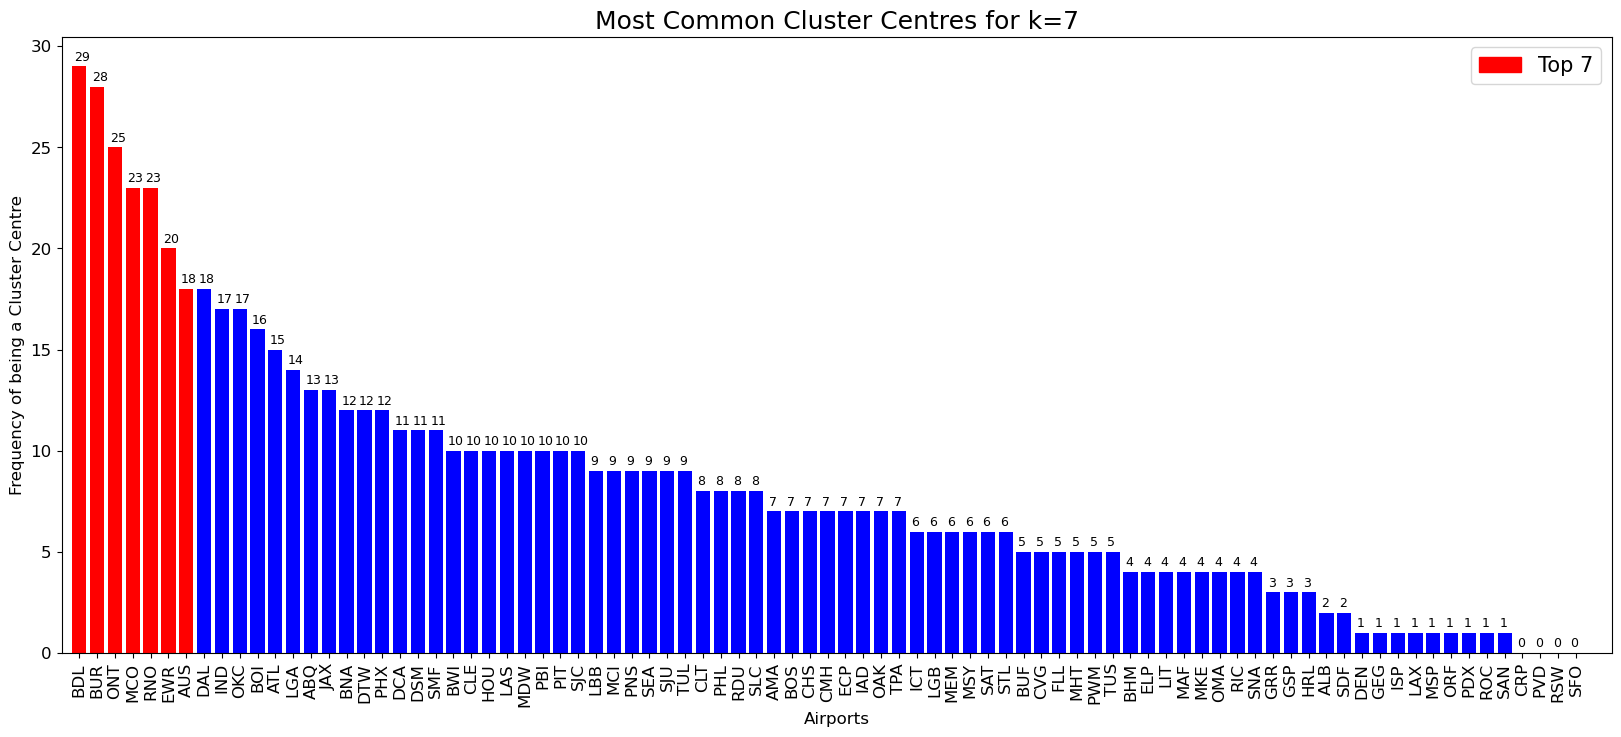

In [9]:
common_centres=dict(sorted(cc_frequency.items(),key=lambda x:x[1],reverse=True))
ccc=sorted(list(common_centres.keys())[:7])
final_centres=sw_airports_location.loc[sw_airports_location['IATA'].isin(ccc)].iloc[:,1:3].values

colors_7=7*['r']+78*['b']
top_7 = mpatches.Patch(color='r', label='Top 7')

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(20,8))
plt.bar(common_centres.keys(), common_centres.values(),color=colors_7)
plt.xticks(rotation='vertical')
plt.xlim(-1,86)
plt.rcParams.update({'font.size': 9})
for index, value in enumerate(common_centres.values()):
    plt.text(index-0.3,value+0.3,str(value))
plt.rcParams.update({'font.size': 15})
plt.title("Most Common Cluster Centres for k=7")
plt.xlabel("Airports")
plt.ylabel("Frequency of being a Cluster Centre")
plt.legend(handles=[top_7])
plt.show()

In [10]:
sw_labels['MCL']=sw_labels.mode(axis=1)[0]
to_drop=['Label_'+str(i) for i in range(1,101)]
sw_labels.drop(columns=to_drop,inplace=True)

for (index,row) in sw_labels.iterrows():
    if row['MCL'] not in ccc:
        a=airport_coordinates[index,:]
        min_dist=np.inf
        for (i,j) in enumerate(final_centres):
            dist=haversine(list(a),list(j))
            if dist<min_dist:
                min_dist=dist
                na=ccc[i]
        row['MCL']=na

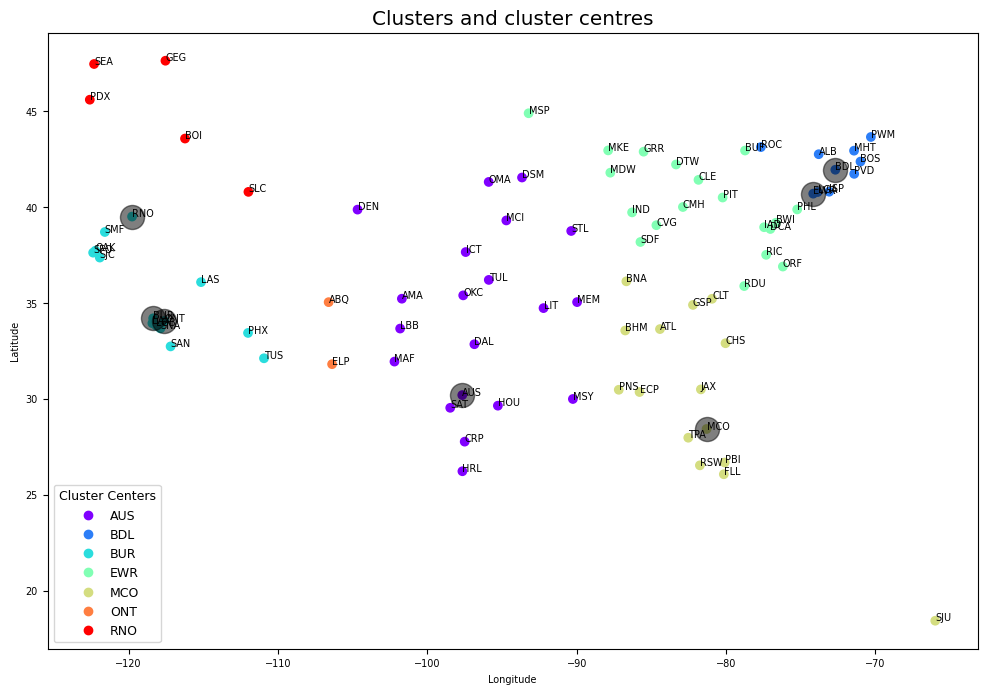

In [11]:
plt.rcParams.update({'font.size': 7})
plt.figure(figsize=(12,8))
scatter=plt.scatter(airport_coordinates[:,1],airport_coordinates[:,0],c=pd.Categorical(sw_labels['MCL'].tolist()).codes,cmap=plt.cm.rainbow)
for i,txt in enumerate(airport_codes):
        plt.annotate(txt,(airport_coordinates[i,1],airport_coordinates[i,0]))
plt.scatter(final_centres[:,1],final_centres[:,0],c='k',marker='o',s=300,alpha=0.5)
plt.rcParams.update({'font.size': 12})
plt.title('Clusters and cluster centres')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.rcParams.update({'font.size': 9})
plt.legend(handles=scatter.legend_elements()[0],labels=ccc,title="Cluster Centers",loc='lower left')
plt.show()